# Causal Inference over a Causal Graph

In [1]:
from IPython.display import clear_output

In [2]:
%pip install dowhy==0.11.1
%pip install gcastle==1.0.3
%pip install econml==0.15.0
%pip install shap==0.45.0
%pip install ipywidgets==8.1.2
clear_output()

In [5]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from dowhy import CausalModel
from dowhy.utils import plot
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from IPython.display import clear_output
from collections import OrderedDict

In [6]:
np.random.seed(0)

## 1. Synthetic data generation

In [7]:
# Note (1): lv0 features may affect both targets an other features of lv1
# Note (2): col_targets are leaf nodes that do not affect oneanother

SAMPLE_SIZE = 1000
col_date = pd.date_range(start='2024-01-01', periods=SAMPLE_SIZE)
col_feature1_lv0 = np.random.random(SAMPLE_SIZE)
col_feature2_lv0 = np.random.random(SAMPLE_SIZE)
col_feature3_lv0 = np.random.random(SAMPLE_SIZE)
col_feature4_lv1 = 0.2*col_feature1_lv0 + 0.67*np.random.random(SAMPLE_SIZE)
col_feature5_lv1 = 0.3*col_feature1_lv0 + 0.1*col_feature2_lv0 + 0.5*col_feature3_lv0 + 0.1*np.random.random(SAMPLE_SIZE)
col_feature6_lv1 = 0.05*col_feature3_lv0 + 0.6*np.random.random(SAMPLE_SIZE)
col_target1 = 0.2*col_feature1_lv0 + 0.1*col_feature2_lv0 + 0.1*col_feature3_lv0 + 0.3*col_feature4_lv1 + 0.2*np.random.random(SAMPLE_SIZE)
col_target2 = 0.1*col_feature1_lv0 + 0.2*col_feature2_lv0 + 0.1*col_feature5_lv1 + 0.4*col_feature6_lv1 + 0.1*np.random.random(SAMPLE_SIZE)
col_target3 = -0.3*col_feature1_lv0 + -0.3*col_feature2_lv0 + -0.1*col_feature5_lv1 + 0.5*np.random.random(SAMPLE_SIZE)

df = pd.DataFrame(
    {
        'col_date': col_date,
        'col_feature1_lv0': col_feature1_lv0,
        'col_feature2_lv0': col_feature2_lv0,
        'col_feature3_lv0': col_feature3_lv0,
        'col_feature4_lv1': col_feature4_lv1,
        'col_feature5_lv1': col_feature5_lv1,
        'col_feature6_lv1': col_feature6_lv1,
        'col_target1': col_target1,
        'col_target2': col_target2,
        'col_target3': col_target3
    }
    )
df.head(5)

,col_date,col_feature1_lv0,col_feature2_lv0,col_feature3_lv0,col_feature4_lv1,col_feature5_lv1,col_feature6_lv1,col_target1,col_target2,col_target3
0,2024-01-01,0.548814,0.592880,0.811518,0.387118,0.658956,0.260644,0.441297,0.403767,-0.179524
1,2024-01-02,0.715189,0.010064,0.476084,0.564882,0.510257,0.202379,0.446854,0.256862,-0.080143
2,2024-01-03,0.602763,0.475826,0.523156,0.642204,0.503731,0.067318,0.549723,0.310955,-0.022782
3,2024-01-04,0.544883,0.708770,0.250521,0.679520,0.394574,0.224043,0.528951,0.414025,-0.311891
4,2024-01-05,0.423655,0.043975,0.605043,0.631727,0.439337,0.169570,0.353248,0.163123,-0.147083


## 2. GCM API

### 2.1. Define the Causal Graph

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from dowhy import gcm

In [ ]:
COLORS = [
    '#00B0F0',
    '#FF0000'
]

In [ ]:
# Define graph dependencies
edges = [
    ('col_feature1_lv0', 'col_feature4_lv1'),
    ('col_feature1_lv0', 'col_feature5_lv1'),
    ('col_feature1_lv0', 'col_target1'),
    ('col_feature1_lv0', 'col_target2'),
    ('col_feature1_lv0', 'col_target3'),

    ('col_feature2_lv0', 'col_feature5_lv1'),
    ('col_feature2_lv0', 'col_target1'),
    ('col_feature2_lv0', 'col_target2'),
    ('col_feature2_lv0', 'col_target3'),

    ('col_feature3_lv0', 'col_feature5_lv1'),
    ('col_feature3_lv0', 'col_feature6_lv1'),
    ('col_feature3_lv0', 'col_target1'),

    ('col_feature4_lv1', 'col_target1'),

    ('col_feature5_lv1', 'col_target2'),
    ('col_feature5_lv1', 'col_target3'),

    ('col_feature6_lv1', 'col_target2')
    ]
graph_nx = nx.DiGraph([(edge[0], edge[1]) for edge in edges])

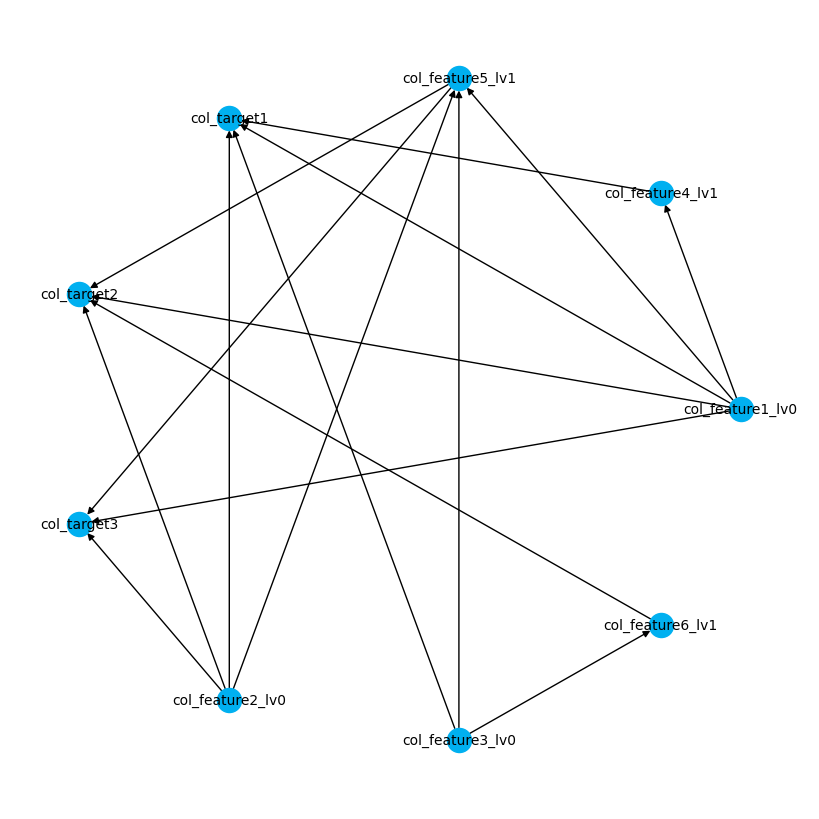

In [ ]:
'''
nx.draw(
    graph_nx,
    with_labels=True,
    node_size=300,
    font_size=10,
    font_color='black',
    node_color=COLORS[0]
)
'''
# larger figure size
plt.figure(3,figsize=(8,8))
pos = nx.circular_layout(graph_nx)
nx.draw(
    graph_nx,
    pos,
    with_labels=True,
    node_size=300,
    font_size=10,
    font_color='black',
    node_color=COLORS[0]
)
plt.show()

In [ ]:
# Target columns
list_cols_lv0    = ['col_feature1_lv0', 'col_feature2_lv0', 'col_feature3_lv0']
list_cols_target = ['col_target1', 'col_target2', 'col_target3']
list_cols_middle = [x for x in list(df.columns) if x not in list_cols_lv0 + list_cols_target and x != 'col_date']

### 2.2. Model the Graph

Reference: https://www.pywhy.org/dowhy/v0.10.1/user_guide/modeling_gcm/graphical_causal_model_types.html

#### Manually assign causal mechanism

In [ ]:
# Define base graph
causal_model = gcm.InvertibleStructuralCausalModel(graph_nx)

# Set lv0/root nodes to empirical distribution
for col_lv0 in list_cols_lv0:
  causal_model.set_causal_mechanism(col_lv0, gcm.EmpiricalDistribution())

# Nodes in the middle and leaf nodes are modeled through a linear model.
for col_not_lv0 in list_cols_middle + list_cols_target:
  causal_model.set_causal_mechanism(col_not_lv0, gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))

gcm.fit(causal_model, df)

Fitting causal mechanism of node col_feature6_lv1: 100%|██████████| 9/9 [00:00<00:00, 95.57it/s]


In [ ]:
# Get arrow strength
# By default, arrow_strength employs KL divergence for measuring the arrow strength for categorical target
# Results in terms of the ouctome variable variance chnage given we remove the edge from the source variable
gcm.arrow_strength(causal_model, 'col_target1')

{('col_feature1_lv0', 'col_target1'): 0.0033095367669833996,
 ('col_feature2_lv0', 'col_target1'): 0.0008737681455027687,
 ('col_feature3_lv0', 'col_target1'): 0.0007450723019557044,
 ('col_feature4_lv1', 'col_target1'): 0.003246995491668957}

In [ ]:
# Check proportions
'''
col_feature1_lv0 should be ~2xmin_ref (by itself, plus 0.3*0.2 = 0.06->~0.5xmin_ref -> 2.5xmin_ref aprox through col_feature4_lv1)
col_feature2_lv0 should be ~1xmin_ref
col_feature3_lv0 should be ~1xmin_ref
col_feature4_lv1 should be 0.67*0.3=0.2 -> ~2xmin_ref (by itself)
'''
dct_strength = gcm.arrow_strength(causal_model, 'col_target1')
ref_val = min(dct_strength.values())
for key, value in dct_strength.items():
  print(key)
  print(value)
  print("Proportion: ", np.round(value/ref_val, 4))

('col_feature1_lv0', 'col_target1')
0.003441337348267947
Proportion:  4.615
('col_feature2_lv0', 'col_target1')
0.0008996472746462906
Proportion:  1.2065
('col_feature3_lv0', 'col_target1')
0.0007456904868324028
Proportion:  1.0
('col_feature4_lv1', 'col_target1')
0.0032991635332235963
Proportion:  4.4243


In [ ]:
# For all target columns
for col_target in list_cols_target:
  print(gcm.arrow_strength(causal_model, col_target))

{('col_feature1_lv0', 'col_target1'): 0.003352682317052635, ('col_feature2_lv0', 'col_target1'): 0.0009231453283969105, ('col_feature3_lv0', 'col_target1'): 0.0007085017393863044, ('col_feature4_lv1', 'col_target1'): 0.00330891904972662}
{('col_feature1_lv0', 'col_target2'): 0.0008531838482554123, ('col_feature2_lv0', 'col_target2'): 0.003705708402131291, ('col_feature5_lv1', 'col_target2'): 0.0003107040344380681, ('col_feature6_lv1', 'col_target2'): 0.004744275925663892}
{('col_feature1_lv0', 'col_target3'): 0.008024855840921713, ('col_feature2_lv0', 'col_target3'): 0.00708589482515079, ('col_feature5_lv1', 'col_target3'): 5.10262566433973e-05}


In [ ]:
# Reference datapoint
X_ref = df.head(1).copy().drop(columns=['col_date'])
X_ref

,col_feature1_lv0,col_feature2_lv0,col_feature3_lv0,col_feature4_lv1,col_feature5_lv1,col_feature6_lv1,col_target1,col_target2,col_target3
0,0.548814,0.59288,0.811518,0.387118,0.658956,0.260644,0.441297,0.403767,-0.179524


#### Counterfactual examples

In [ ]:
# Generate counterfactual samples - see the influence of increases on the different features (level 0)
ref_increase = 1
for col_lvl0 in list_cols_lv0:
  print("*"*70)
  print(f"Increase of {ref_increase} in {col_lvl0}")
  df_exp = (
    gcm.counterfactual_samples(
        causal_model,
        {col_lvl0: lambda x: X_ref[col_lvl0].values[0] + ref_increase},
        observed_data=X_ref
        )
  )
  df_exp = (
      df_exp
      .T
      .reset_index()
      .rename(columns={0:'counter_value'})
      .merge(
          X_ref
          .T
          .reset_index()
          .rename(columns={0:'ref_value'})
          )
      .sort_values(by=['index'])
  )
  df_exp['feature_importance'] = df_exp['counter_value'] - df_exp['ref_value']
  df_exp = df_exp[df_exp['index'] != col_lvl0] # Remove iter column
  display(df_exp)
  print("*"*70)

**********************************************************************
Increase of 1 in col_feature1_lv0


,index,counter_value,ref_value,feature_importance
1,col_feature2_lv0,0.592880,0.592880,0.000000
2,col_feature3_lv0,0.811518,0.811518,0.000000
3,col_feature4_lv1,0.569056,0.387118,0.181938
4,col_feature5_lv1,0.958803,0.658956,0.299848
5,col_feature6_lv1,0.260644,0.260644,0.000000
6,col_target1,0.695056,0.441297,0.253759
8,col_target2,0.533463,0.403767,0.129697
7,col_target3,-0.496433,-0.179524,-0.316910


**********************************************************************
**********************************************************************
Increase of 1 in col_feature2_lv0


,index,counter_value,ref_value,feature_importance
0,col_feature1_lv0,0.548814,0.548814,0.000000
2,col_feature3_lv0,0.811518,0.811518,0.000000
3,col_feature4_lv1,0.387118,0.387118,0.000000
4,col_feature5_lv1,0.757298,0.658956,0.098342
5,col_feature6_lv1,0.260644,0.260644,0.000000
6,col_target1,0.541520,0.441297,0.100223
8,col_target2,0.615725,0.403767,0.211959
7,col_target3,-0.472677,-0.179524,-0.293153


**********************************************************************
**********************************************************************
Increase of 1 in col_feature3_lv0


,index,counter_value,ref_value,feature_importance
0,col_feature1_lv0,0.548814,0.548814,0.000000
1,col_feature2_lv0,0.592880,0.592880,0.000000
3,col_feature4_lv1,0.387118,0.387118,0.000000
4,col_feature5_lv1,1.155218,0.658956,0.496262
5,col_feature6_lv1,0.303814,0.260644,0.043170
6,col_target1,0.537041,0.441297,0.095745
8,col_target2,0.471526,0.403767,0.067759
7,col_target3,-0.208497,-0.179524,-0.028974


**********************************************************************


In [ ]:
'''
# Generate counterfactual samples - see the influence of increases on the different features (level 0)
# Alternative -> set the counter value t 0 in the ref datapoint
ref_increase = 1
for col_lvl0 in list_cols_lv0:
  print("*"*70)
  print(f"Increase of {ref_increase} in {col_lvl0}")
  X_iter = X_ref.copy()
  X_iter[col_lvl0] = 0


  df_exp = (
    gcm.counterfactual_samples(
        causal_model,
        {col_lvl0: lambda x: ref_increase},
        observed_data=X_iter
        )
  )
  #df_exp = df_exp[df_exp['index'] != col_lvl0] # Remove iter column
  display(df_exp)
  print("*"*70)
'''
print()

#### Interventional examples

In [ ]:
# Interventional examples; what happens if we fix the value of a node to a target reference?
samples = gcm.interventional_samples(
    causal_model,
    {
        'col_feature1_lv0': lambda x: 1,
        #'col_feature2_lv0': lambda x: 1,
        #'col_feature3_lv0': lambda x: 1
    },
    num_samples_to_draw=1000
)
samples.head()

,col_feature1_lv0,col_feature2_lv0,col_feature3_lv0,col_feature4_lv1,col_feature5_lv1,col_feature6_lv1,col_target1,col_target3,col_target2
0,1,0.588158,0.038018,0.569779,0.385122,0.237060,0.471665,-0.021585,0.432032
1,1,0.326942,0.518432,0.556815,0.642075,0.330962,0.587259,-0.421336,0.441109
2,1,0.203621,0.426820,0.377274,0.592239,0.485332,0.542164,0.067242,0.401059
3,1,0.693747,0.038018,0.689105,0.464601,0.373957,0.538180,-0.315618,0.446515
4,1,0.456704,0.881067,0.639811,0.871472,0.064603,0.672563,-0.071650,0.404865


In [ ]:
# Interventional examples; what happens if we fix the value of a node to a target reference?
samples = gcm.interventional_samples(
    causal_model,
    {
        'col_feature1_lv0': lambda x: 1,
        'col_feature2_lv0': lambda x: 1,
        'col_feature3_lv0': lambda x: 1
    },
    num_samples_to_draw=1000
)
samples.head()

,col_feature1_lv0,col_feature2_lv0,col_feature3_lv0,col_feature4_lv1,col_feature5_lv1,col_feature6_lv1,col_target1,col_target3,col_target2
0,1,1,1,0.204302,0.927965,0.076642,0.587683,-0.525953,0.517848
1,1,1,1,0.744863,0.968497,0.131877,0.781400,-0.215846,0.510419
2,1,1,1,0.665090,0.917204,0.294139,0.741198,-0.365493,0.577165
3,1,1,1,0.732115,0.939221,0.502995,0.747642,-0.463853,0.634641
4,1,1,1,0.259043,0.921930,0.490875,0.525949,-0.377082,0.630023


#### Confidence Intervals

In [ ]:
'''
# Confidence intervals
col_root = 'col_feature1_lv0'
col_check = 'col_feature4_lv1'
X_new = X_ref.copy()
X_new[col_root] = X_ref[col_root].values[0] + ref_increase
gcm.confidence_intervals(
    lambda: gcm.distribution_change(
        causal_model,
        X_ref,
        X_new,
        target_node=col_check
        )
    )
'''
print()

In [ ]:
# Confidence intervals
list_results = []
for col_check in list_cols_middle:
  print("*"*70)
  print(f"Analysis for {col_check}")
  strength_median, strength_intervals = gcm.confidence_intervals(
      gcm.fit_and_compute(gcm.arrow_strength,
                          causal_model,
                          bootstrap_training_data=df,
                          target_node=col_check))
  print(strength_median, strength_intervals)
  clear_output()
  list_results.append((strength_median, strength_intervals))
  print("*"*70)

**********************************************************************


In [ ]:
for item in list_results:
  print(item)

({('col_feature1_lv0', 'col_feature4_lv1'): 0.002588813468101408}, {('col_feature1_lv0', 'col_feature4_lv1'): array([0.00210499, 0.00320371])})
({('col_feature1_lv0', 'col_feature5_lv1'): 0.007606816310126975, ('col_feature2_lv0', 'col_feature5_lv1'): 0.0008614660366511136, ('col_feature3_lv0', 'col_feature5_lv1'): 0.020228631104668146}, {('col_feature1_lv0', 'col_feature5_lv1'): array([0.00742596, 0.00784574]), ('col_feature2_lv0', 'col_feature5_lv1'): array([0.00082435, 0.00097059]), ('col_feature3_lv0', 'col_feature5_lv1'): array([0.01961125, 0.02099879])})
({('col_feature3_lv0', 'col_feature6_lv1'): 0.00013954458496496334}, {('col_feature3_lv0', 'col_feature6_lv1'): array([5.20423461e-05, 3.38236606e-04])})


In [ ]:
# CI alternative (withoout retraining)
# Confidence intervals
list_results = []
for col_check in list_cols_middle:
  print("*"*70)
  print(f"Analysis for {col_check}")
  strength_median, strength_intervals = gcm.confidence_intervals(
    gcm.bootstrap_sampling(gcm.arrow_strength,
                           causal_model,
                           target_node=col_check))

  print(strength_median, strength_intervals)
  clear_output()
  list_results.append((strength_median, strength_intervals))
  print("*"*70)

**********************************************************************


In [ ]:
for item in list_results:
  print(item)

({('col_feature1_lv0', 'col_feature4_lv1'): 0.002709065490674756}, {('col_feature1_lv0', 'col_feature4_lv1'): array([0.00249141, 0.00315521])})
({('col_feature1_lv0', 'col_feature5_lv1'): 0.007615440857675887, ('col_feature2_lv0', 'col_feature5_lv1'): 0.000866010192229214, ('col_feature3_lv0', 'col_feature5_lv1'): 0.020238589040039803}, {('col_feature1_lv0', 'col_feature5_lv1'): array([0.00749083, 0.00772266]), ('col_feature2_lv0', 'col_feature5_lv1'): array([0.00083521, 0.00088851]), ('col_feature3_lv0', 'col_feature5_lv1'): array([0.01998789, 0.0206256 ])})
({('col_feature3_lv0', 'col_feature6_lv1'): 0.00018134446847776667}, {('col_feature3_lv0', 'col_feature6_lv1'): array([0.00013099, 0.00027377])})


#### New predictions

In [ ]:
# New predictions
'''
col_target_check =

col_root = 'col_feature1_lv0'
col_check = 'col_feature4_lv1'
X_new = X_ref.copy()
X_new[col_root] = X_ref[col_root].values[0] + ref_increase
gcm.distribution_change(
  causal_model,
  X_ref,
  X_new,
  target_node=col_check
  )
'''

# Reference input nodes
X_test = df[4:5].copy().drop(columns=['col_date'])
y_test = X_test[list_cols_target].copy()
#X_test = X_test.drop(columns=list_cols_target)[list_cols_lv0]
X_test = X_test.drop(columns=list_cols_target)

#dct_input = {col_input: lambda x: X_test[col_input].values[0] for col_input in list(X_test.columns)}
dct_input = OrderedDict()
for col_input in list(X_test.columns):
  value_iter = X_test[col_input].values[0]
  constant_lambda = lambda x, value=value_iter: value
  dct_input[col_input] = constant_lambda

X_pred = gcm.interventional_samples(
    causal_model,
    dct_input,
    num_samples_to_draw=1000
)
y_pred = pd.DataFrame(X_pred[list_cols_target].mean()).T
display(X_pred.head(2))
display(y_pred)
display(y_test)
'''
samples = gcm.interventional_samples(
    causal_model,
    {
        'col_feature1_lv0': lambda x: 1,
        'col_feature2_lv0': lambda x: 1,
        'col_feature3_lv0': lambda x: 1
    },
    num_samples_to_draw=1000
)
samples.head()
'''
print()

,col_feature1_lv0,col_feature2_lv0,col_feature3_lv0,col_feature4_lv1,col_feature5_lv1,col_feature6_lv1,col_target1,col_target3,col_target2
0,0.423655,0.043975,0.605043,0.631727,0.439337,0.16957,0.449908,0.125553,0.241499
1,0.423655,0.043975,0.605043,0.631727,0.439337,0.16957,0.412990,0.189828,0.238589
2,0.423655,0.043975,0.605043,0.631727,0.439337,0.16957,0.473994,-0.173265,0.200897
3,0.423655,0.043975,0.605043,0.631727,0.439337,0.16957,0.385521,0.276151,0.231159
4,0.423655,0.043975,0.605043,0.631727,0.439337,0.16957,0.421088,0.171599,0.186687
...,...,...,...,...,...,...,...,...,...
495,0.423655,0.043975,0.605043,0.631727,0.439337,0.16957,0.520543,0.030690,0.238888
496,0.423655,0.043975,0.605043,0.631727,0.439337,0.16957,0.347793,0.169605,0.169046
497,0.423655,0.043975,0.605043,0.631727,0.439337,0.16957,0.462996,0.200519,0.215169
498,0.423655,0.043975,0.605043,0.631727,0.439337,0.16957,0.518681,0.017490,0.187342


,col_target1,col_target2,col_target3
0,0.435521,0.211387,0.071057


,col_target1,col_target2,col_target3
4,0.353248,0.163123,-0.147083


In [ ]:
# Check one datapoint
X_pred = gcm.interventional_samples(
    causal_model,
    {
     'col_feature1_lv0': lambda x: 0.423655,
     'col_feature2_lv0': lambda x: 0.043975,
     'col_feature3_lv0': lambda x: 0.605043,
     'col_feature4_lv1': lambda x: 0.631727,
     'col_feature5_lv1': lambda x: 0.439337,
     'col_feature6_lv1': lambda x: 0.16957,
    },
    num_samples_to_draw=2500
)
#y_pred = pd.DataFrame(X_pred[list_cols_target].min()).T
y_pred = pd.DataFrame(X_pred[list_cols_target].mean()).T
display(X_pred.head(2))
display(y_pred)
display(y_test)

,col_feature1_lv0,col_feature2_lv0,col_feature3_lv0,col_feature4_lv1,col_feature5_lv1,col_feature6_lv1,col_target1,col_target3,col_target2
0,0.423655,0.043975,0.605043,0.631727,0.439337,0.16957,0.502211,0.247721,0.175972
1,0.423655,0.043975,0.605043,0.631727,0.439337,0.16957,0.402362,0.291229,0.165213


,col_target1,col_target2,col_target3
0,0.436636,0.212006,0.053596


,col_target1,col_target2,col_target3
4,0.353248,0.163123,-0.147083


['col_feature1_lv0', 'col_feature2_lv0', 'col_feature3_lv0']

In [ ]:
# New predictions
# Draw several samples, and avg the results to estimate the predicitons
# Only intervene in lvl0 nodes

# Reference input nodes
X_test = df[4:5].copy().drop(columns=['col_date'])
y_test = X_test[list_cols_target].copy()
X_test = X_test.drop(columns=list_cols_target)[list_cols_lv0]
print(X_test.columns)
#dct_input = {col_input: lambda x: X_test[col_input].values[0] for col_input in list(X_test.columns)}
dct_input = OrderedDict()
for col_input in list(X_test.columns):
  value_iter = X_test[col_input].values[0]
  constant_lambda = lambda x, value=value_iter: value
  dct_input[col_input] = constant_lambda

X_pred = gcm.interventional_samples(
    causal_model,
    dct_input,
    num_samples_to_draw=1000
)
display(X_pred.head())
display(pd.DataFrame(X_pred[list_cols_target].mean()).T)
display(y_test)

print()

Index(['col_feature1_lv0', 'col_feature2_lv0', 'col_feature3_lv0'], dtype='object')


,col_feature1_lv0,col_feature2_lv0,col_feature3_lv0,col_feature4_lv1,col_feature5_lv1,col_feature6_lv1,col_target1,col_target3,col_target2
0,0.423655,0.043975,0.605043,0.343678,0.456443,0.296786,0.294930,0.216253,0.273162
1,0.423655,0.043975,0.605043,0.648931,0.503776,0.304179,0.352736,0.039026,0.315221
2,0.423655,0.043975,0.605043,0.439123,0.527793,0.428497,0.410959,-0.073373,0.309239
3,0.423655,0.043975,0.605043,0.249587,0.454995,0.175151,0.421891,0.068003,0.243789
4,0.423655,0.043975,0.605043,0.172778,0.484267,0.432008,0.336729,0.174722,0.320176


,col_target1,col_target2,col_target3
0,0.371155,0.281373,0.053153


,col_target1,col_target2,col_target3
4,0.353248,0.163123,-0.147083


In [ ]:
X_ref

,col_feature1_lv0,col_feature2_lv0,col_feature3_lv0,col_feature4_lv1,col_feature5_lv1,col_feature6_lv1,col_target1,col_target2,col_target3
0,0.548814,0.59288,0.811518,0.387118,0.658956,0.260644,0.441297,0.403767,-0.179524


In [ ]:
# Reference datapoints
X_test = df[4:5].copy().drop(columns=['col_date'])
y_test = X_test[list_cols_target].copy()
X_test = X_test.drop(columns=list_cols_target)[list_cols_lv0]
dct_input = {col_input: lambda x: X_test[col_input].values[0] for col_input in list(X_test.columns)}
dct_input_base = {col_input: lambda x: 0 for col_input in list(X_test.columns)}

# Average causal effect
idx_check = 0
estim_effect = gcm.average_causal_effect(
    causal_model,
    list_cols_target[idx_check],
    interventions_alternative=dct_input,
    interventions_reference=dct_input_base,
    num_samples_to_draw=1000 # Using a sampling
)
print(list_cols_target[idx_check])
print(y_test[list_cols_target[idx_check]].values[0], estim_effect)

col_target1
0.3532476440676608 0.272533278542355


In [ ]:
# Reference datapoints
X_test = df[4:5].copy().drop(columns=['col_date'])
y_test = X_test[list_cols_target].copy()
X_test = X_test.drop(columns=list_cols_target)[list_cols_lv0]
dct_input = {col_input: lambda x: X_test[col_input].values[0] for col_input in list(X_test.columns)}
dct_input_base = {col_input: lambda x: 0 for col_input in list(X_test.columns)}

# Average causal effect
idx_check = 0
estim_effect = gcm.average_causal_effect(
    causal_model,
    list_cols_target[idx_check],
    interventions_alternative=dct_input,
    interventions_reference=dct_input_base,
    observed_data=df # Using the original data
)
print(list_cols_target[idx_check])
print(y_test[list_cols_target[idx_check]].values[0], estim_effect)

col_target1
0.3532476440676608 0.2657303322030344


#### Feature importance

In [ ]:
target_node = list_cols_target[0]
parent_relevance, noise_relevance = gcm.parent_relevance(
  causal_model,
  target_node=target_node
)

Evaluate set function: 32it [00:44,  1.38s/it]


In [ ]:
print(parent_relevance)
print()
print(noise_relevance)

{('col_feature1_lv0', 'col_target1'): 0.004376835226101317, ('col_feature2_lv0', 'col_target1'): 0.0009086026407716703, ('col_feature3_lv0', 'col_target1'): 0.0007477891364516449, ('col_feature4_lv1', 'col_target1'): 0.004290959346249723}

[0.00333881]


In [ ]:
ref_val = min(parent_relevance.values())
for key, value in parent_relevance.items():
  print(key)
  print(value)
  print("Proportion: ", np.round(value/ref_val, 4))

('col_feature1_lv0', 'col_target1')
0.004376835226101317
Proportion:  5.853
('col_feature2_lv0', 'col_target1')
0.0009086026407716703
Proportion:  1.2151
('col_feature3_lv0', 'col_target1')
0.0007477891364516449
Proportion:  1.0
('col_feature4_lv1', 'col_target1')
0.004290959346249723
Proportion:  5.7382


In [ ]:
# Estimate causal effects
for col_target_iter in list_cols_middle + list_cols_target:
  print("*"*50)
  print(col_target_iter)
  list_col_nodes_iter = list(set([edge[0] for edge in edges if edge[1]==col_target_iter]))
  for col_node in list_col_nodes_iter:
    result = gcm.average_causal_effect(
        causal_model,
        col_target_iter,
        interventions_alternative={col_node: lambda x: 1},
        interventions_reference={col_node: lambda x: 0},
        num_samples_to_draw=2000
    )
    print(col_node, ":", np.round(result, 3))
  print("*"*50)
  print()

**************************************************
col_feature4_lv1
col_feature1_lv0 : 0.185
**************************************************

**************************************************
col_feature5_lv1
col_feature2_lv0 : 0.099
col_feature3_lv0 : 0.497
col_feature1_lv0 : 0.299
**************************************************

**************************************************
col_feature6_lv1
col_feature3_lv0 : 0.037
**************************************************

**************************************************
col_target1
col_feature4_lv1 : 0.29
col_feature2_lv0 : 0.098
col_feature3_lv0 : 0.095
col_feature1_lv0 : 0.257
**************************************************

**************************************************
col_target2
col_feature2_lv0 : 0.212
col_feature6_lv1 : 0.398
col_feature1_lv0 : 0.13
col_feature5_lv1 : 0.102
**************************************************

**************************************************
col_target3
col_feature2_lv0 : -0.30

### Predictions (alternative)

In [ ]:
# Predictions based on constant causal effects coefficients
df_coeff = pd.DataFrame()
for col_target_iter in list_cols_target: # Keep only final nodes
  print("*"*50)
  print(col_target_iter)
  list_col_nodes_iter = list(set([edge[0] for edge in edges if edge[1]==col_target_iter]))
  for col_node in list_col_nodes_iter:
    result = gcm.average_causal_effect(
        causal_model,
        col_target_iter,
        interventions_alternative = {col_node: lambda x: 1},
        interventions_reference   = {col_node: lambda x: 0},
        num_samples_to_draw=2000
    )
    print(col_node, ":", np.round(result, 3))
    df_coeff_iter = pd.DataFrame(
        {
            'col_root':   [col_node],
            'col_target': [col_target_iter],
            'feature_importance': [result]
        }
        )
    df_coeff = pd.concat([df_coeff, df_coeff_iter])
  print("*"*50)
  print()
df_coeff.head()

**************************************************
col_target1
col_feature4_lv1 : 0.285
col_feature2_lv0 : 0.101
col_feature3_lv0 : 0.097
col_feature1_lv0 : 0.255
**************************************************

**************************************************
col_target2
col_feature2_lv0 : 0.211
col_feature6_lv1 : 0.398
col_feature1_lv0 : 0.128
col_feature5_lv1 : 0.103
**************************************************

**************************************************
col_target3
col_feature2_lv0 : -0.294
col_feature1_lv0 : -0.32
col_feature5_lv1 : -0.067
**************************************************



,col_root,col_target,feature_importance
0,col_feature4_lv1,col_target1,0.285043
0,col_feature2_lv0,col_target1,0.101337
0,col_feature3_lv0,col_target1,0.096657
0,col_feature1_lv0,col_target1,0.254565
0,col_feature2_lv0,col_target2,0.211331


In [ ]:
# Check for one datapoint
X_test = df[4:5].copy().drop(columns=['col_date'])
y_test = X_test[list_cols_target].copy()
#X_test = X_test.drop(columns=list_cols_target)[list_cols_lv0]
X_test = X_test.drop(columns=list_cols_target)

df_coeff['y_pred_aux'] = df_coeff.apply(
    lambda x: x['feature_importance']*X_test[x['col_root']], axis=1
)
display(df_coeff[['col_target', 'y_pred_aux']].groupby(by=['col_target']).sum().reset_index())
display(y_test)

,col_target,y_pred_aux
0,col_target1,0.350855
1,col_target2,0.176667
2,col_target3,-0.178121


,col_target1,col_target2,col_target3
4,0.353248,0.163123,-0.147083


### 2.3. Model the Graph with known relationships

Here, we include some known relationships within the graph

Reference: https://www.pywhy.org/dowhy/v0.10.1/user_guide/modeling_gcm/customizing_model_assignment.html

In [ ]:
import dowhy.gcm.ml.prediction_model

In [ ]:
class MyCustomModel(gcm.ml.PredictionModel):
    def __init__(self, coefficient):
        self.coefficient = coefficient

    def fit(self, X, Y):
        # Nothing to fit here, since we know the ground truth.
        pass

    def predict(self, X):
        return self.coefficient * X

    def clone(self):
        return MyCustomModel(self.coefficient)

In [ ]:
# Define base graph
causal_model = gcm.InvertibleStructuralCausalModel(graph_nx)

# Set lv0/root nodes to empirical distribution
for col_lv0 in list_cols_lv0:
  causal_model.set_causal_mechanism(col_lv0, gcm.EmpiricalDistribution())

# Nodes in the middle and leaf nodes are modeled through a linear model.
for col_not_lv0 in list_cols_middle + list_cols_target:
  if col_not_lv0 != 'col_feature6_lv1':
    causal_model.set_causal_mechanism(col_not_lv0, gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
  else:
    causal_model.set_causal_mechanism(col_not_lv0, gcm.AdditiveNoiseModel(MyCustomModel(0.05)))

gcm.fit(causal_model, df)

Fitting causal mechanism of node col_feature6_lv1: 100%|██████████| 9/9 [00:00<00:00, 166.32it/s]


In [ ]:
# Generate counterfactual samples - see the influence of increases on the different features (level 0)
ref_increase = 1
for col_lvl0 in list_cols_lv0:
  print("*"*70)
  print(f"Increase of {ref_increase} in {col_lvl0}")
  df_exp = (
    gcm.counterfactual_samples(
        causal_model,
        {col_lvl0: lambda x: X_ref[col_lvl0].values[0] + ref_increase},
        observed_data=X_ref
        )
  )
  df_exp = (
      df_exp
      .T
      .reset_index()
      .rename(columns={0:'counter_value'})
      .merge(
          X_ref
          .T
          .reset_index()
          .rename(columns={0:'ref_value'})
          )
      .sort_values(by=['index'])
  )
  df_exp['feature_importance'] = df_exp['counter_value'] - df_exp['ref_value']
  df_exp = df_exp[df_exp['index'] != col_lvl0] # Remove iter column
  display(df_exp)
  print("*"*70)

**********************************************************************
Increase of 1 in col_feature1_lv0


,index,counter_value,ref_value,feature_importance
1,col_feature2_lv0,0.592880,0.592880,0.000000
2,col_feature3_lv0,0.811518,0.811518,0.000000
3,col_feature4_lv1,0.569056,0.387118,0.181938
4,col_feature5_lv1,0.958803,0.658956,0.299848
5,col_feature6_lv1,0.260644,0.260644,0.000000
6,col_target1,0.695056,0.441297,0.253759
8,col_target2,0.533463,0.403767,0.129697
7,col_target3,-0.496433,-0.179524,-0.316910


**********************************************************************
**********************************************************************
Increase of 1 in col_feature2_lv0


,index,counter_value,ref_value,feature_importance
0,col_feature1_lv0,0.548814,0.548814,0.000000
2,col_feature3_lv0,0.811518,0.811518,0.000000
3,col_feature4_lv1,0.387118,0.387118,0.000000
4,col_feature5_lv1,0.757298,0.658956,0.098342
5,col_feature6_lv1,0.260644,0.260644,0.000000
6,col_target1,0.541520,0.441297,0.100223
8,col_target2,0.615725,0.403767,0.211959
7,col_target3,-0.472677,-0.179524,-0.293153


**********************************************************************
**********************************************************************
Increase of 1 in col_feature3_lv0


,index,counter_value,ref_value,feature_importance
0,col_feature1_lv0,0.548814,0.548814,0.000000
1,col_feature2_lv0,0.592880,0.592880,0.000000
3,col_feature4_lv1,0.387118,0.387118,0.000000
4,col_feature5_lv1,1.155218,0.658956,0.496262
5,col_feature6_lv1,0.310644,0.260644,0.050000
6,col_target1,0.537041,0.441297,0.095745
8,col_target2,0.474243,0.403767,0.070477
7,col_target3,-0.208497,-0.179524,-0.028974


**********************************************************************


In [ ]:
# Estimate causal effects
for col_target_iter in list_cols_middle + list_cols_target:
  print("*"*50)
  print(col_target_iter)
  list_col_nodes_iter = list(set([edge[0] for edge in edges if edge[1]==col_target_iter]))
  for col_node in list_col_nodes_iter:
    result = gcm.average_causal_effect(
        causal_model,
        col_target_iter,
        interventions_alternative={col_node: lambda x: 1},
        interventions_reference={col_node: lambda x: 0},
        num_samples_to_draw=2000
    )
    print(col_node, ":", np.round(result, 3))
  print("*"*50)
  print()

**************************************************
col_feature4_lv1
col_feature1_lv0 : 0.178
**************************************************

**************************************************
col_feature5_lv1
col_feature2_lv0 : 0.098
col_feature3_lv0 : 0.496
col_feature1_lv0 : 0.301
**************************************************

**************************************************
col_feature6_lv1
col_feature3_lv0 : 0.05
**************************************************

**************************************************
col_target1
col_feature4_lv1 : 0.286
col_feature2_lv0 : 0.099
col_feature3_lv0 : 0.098
col_feature1_lv0 : 0.256
**************************************************

**************************************************
col_target2
col_feature2_lv0 : 0.212
col_feature6_lv1 : 0.398
col_feature1_lv0 : 0.129
col_feature5_lv1 : 0.102
**************************************************

**************************************************
col_target3
col_feature2_lv0 : -0.2

We see that the relationship for col_feature6_lv1 is exaclty 0.05 for col_feature3_lv0, and 0 for the other root nodes.

In [ ]:
# TODO: Evaluations?
# TODO: Other models besides linear regression?
# TODO: Relationship significance?
# TODO: Include a causal discovery example

### 2.4. Root Cause Analysis

Reference: https://www.pywhy.org/dowhy/v0.10.1/user_guide/causal_tasks/root_causing_and_explaining/index.html

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from dowhy import gcm

#### Auto assign causal mechanism
Auto assign instead of manual

In [ ]:
# Define base graph
causal_model = gcm.InvertibleStructuralCausalModel(graph_nx)

# Auto-assign causal mechanism (instead of manual)
gcm.auto.assign_causal_mechanisms(causal_model, df)
gcm.fit(causal_model, df)

Fitting causal mechanism of node col_feature6_lv1: 100%|██████████| 9/9 [00:00<00:00, 134.43it/s]


In [ ]:
# Get arrow strength
gcm.arrow_strength(causal_model, 'col_target1')

{('col_feature1_lv0', 'col_target1'): 0.003426260926023136,
 ('col_feature2_lv0', 'col_target1'): 0.0008444733342261585,
 ('col_feature3_lv0', 'col_target1'): 0.0007843775979006066,
 ('col_feature4_lv1', 'col_target1'): 0.003189669284240742}

#### Anomalous attribution

For an anomalous datapoint, check the features responsible for it

In [ ]:
# Perform RCA over an anomaly in a leaf node.
# Reference: https://www.pywhy.org/dowhy/v0.11.1/getting_started/index.html
def generate_anomalous_sample(X_ref, anomalous_val_1):
  """
  Funtion that generates a real anomalous datapoint based on the original
  synthetic data distribution
  """
  col_feature1_lv0 = anomalous_val_1
  col_feature2_lv0 = X_ref['col_feature2_lv0'].values[0]
  col_feature3_lv0 = X_ref['col_feature3_lv0'].values[0]
  col_feature4_lv1 = 0.2*col_feature1_lv0 + 0.67*np.random.random(1)[0]
  col_feature5_lv1 = 0.3*col_feature1_lv0 + 0.1*col_feature2_lv0 + 0.5*col_feature3_lv0 + 0.1*np.random.random(1)[0]
  col_feature6_lv1 = 0.05*col_feature3_lv0 + 0.6*np.random.random(1)[0]
  col_target1 = 0.2*col_feature1_lv0 + 0.1*col_feature2_lv0 + 0.1*col_feature3_lv0 + 0.3*col_feature4_lv1 + 0.2*np.random.random(1)[0]
  col_target2 = 0.1*col_feature1_lv0 + 0.2*col_feature2_lv0 + 0.1*col_feature5_lv1 + 0.4*col_feature6_lv1 + 0.1*np.random.random(1)[0]
  col_target3 = -0.3*col_feature1_lv0 + -0.3*col_feature2_lv0 + -0.1*col_feature5_lv1 + 0.5*np.random.random(1)[0]

  df = pd.DataFrame(
    {
        'col_feature1_lv0': [col_feature1_lv0],
        'col_feature2_lv0': [col_feature2_lv0],
        'col_feature3_lv0': [col_feature3_lv0],
        'col_feature4_lv1': [col_feature4_lv1],
        'col_feature5_lv1': [col_feature5_lv1],
        'col_feature6_lv1': [col_feature6_lv1],
        'col_target1': [col_target1],
        'col_target2': [col_target2],
        'col_target3': [col_target3]
    }
    )
  return df

anomalous_sample = generate_anomalous_sample(X_ref, anomalous_val_1=4) # Here, col_feature1_lv0 is the root cause.

# Which node is the root cause of the anomaly in col_target2?
anomaly_attribution = gcm.attribute_anomalies(causal_model, "col_target2", anomalous_sample)
clear_output()
print(anomaly_attribution)

{'col_feature1_lv0': array([7.86295258]), 'col_feature2_lv0': array([-0.09567509]), 'col_feature3_lv0': array([0.30183121]), 'col_feature5_lv1': array([0.19544476]), 'col_feature6_lv1': array([-0.15383088]), 'col_target2': array([-0.10402173])}


#### Distributional change

In [ ]:
# Distributional chnage -> change in col_target1
SAMPLE_SIZE = 1000
col_date = pd.date_range(start='2024-01-01', periods=SAMPLE_SIZE)
col_feature1_lv0 = np.random.random(SAMPLE_SIZE)
col_feature2_lv0 = np.random.random(SAMPLE_SIZE)
col_feature3_lv0 = np.random.random(SAMPLE_SIZE)
col_feature4_lv1 = 0.5*col_feature2_lv0 + 0.1*np.random.random(SAMPLE_SIZE) # Change in this feature
col_feature5_lv1 = 0.3*col_feature1_lv0 + 0.1*col_feature2_lv0 + 0.5*col_feature3_lv0 + 0.1*np.random.random(SAMPLE_SIZE)
col_feature6_lv1 = 0.05*col_feature3_lv0 + 0.6*np.random.random(SAMPLE_SIZE)
col_target1 = 0.2*col_feature1_lv0 + 0.1*col_feature2_lv0 + 0.1*col_feature3_lv0 + 0.3*col_feature4_lv1 + 0.2*np.random.random(SAMPLE_SIZE)
col_target2 = 0.1*col_feature1_lv0 + 0.2*col_feature2_lv0 + 0.1*col_feature5_lv1 + 0.4*col_feature6_lv1 + 0.1*np.random.random(SAMPLE_SIZE)
col_target3 = -0.3*col_feature1_lv0 + -0.3*col_feature2_lv0 + -0.1*col_feature5_lv1 + 0.5*np.random.random(SAMPLE_SIZE)

df_new = pd.DataFrame(
    {
        'col_date': col_date,
        'col_feature1_lv0': col_feature1_lv0,
        'col_feature2_lv0': col_feature2_lv0,
        'col_feature3_lv0': col_feature3_lv0,
        'col_feature4_lv1': col_feature4_lv1,
        'col_feature5_lv1': col_feature5_lv1,
        'col_feature6_lv1': col_feature6_lv1,
        'col_target1': col_target1,
        'col_target2': col_target2,
        'col_target3': col_target3
    }
    )
df_new.head(5)

,col_date,col_feature1_lv0,col_feature2_lv0,col_feature3_lv0,col_feature4_lv1,col_feature5_lv1,col_feature6_lv1,col_target1,col_target2,col_target3
0,2024-01-01,0.598318,0.962566,0.097828,0.490855,0.342131,0.082441,0.551795,0.332405,-0.287640
1,2024-01-02,0.765561,0.185913,0.510362,0.142233,0.550557,0.448267,0.426869,0.412369,-0.059622
2,2024-01-03,0.669488,0.161568,0.962488,0.113266,0.772725,0.249865,0.419872,0.297974,0.098848
3,2024-01-04,0.705870,0.300557,0.104285,0.197881,0.349086,0.487059,0.257000,0.411936,-0.260453
4,2024-01-05,0.868623,0.087483,0.357642,0.089649,0.506728,0.519549,0.295693,0.461794,0.046837


In [ ]:
attributions = gcm.distribution_change(
    causal_model,
    df,
    df_new,
    "col_target1"
)
clear_output()
print(attributions) # Change is attributed mainly to col_feature4_lv1

{'col_feature1_lv0': 0.015630658791031288, 'col_feature2_lv0': 0.017518321431840178, 'col_feature3_lv0': 0.0006321926414081802, 'col_feature4_lv1': 0.08939449144095724, 'col_target1': 0.011893425483754206}


#### Distributional change - full example

We now have two binary columns, where the change in one of them changes the distribution of the target nodes (and the other one doesn't).

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from dowhy import gcm

In [ ]:
# Original data
# Here, the binary columns are set to 1, but only one of them affects one of the outputs
SAMPLE_SIZE = 1000
ini_date = '2024-01-01'
col_date = pd.date_range(start=ini_date, periods=SAMPLE_SIZE)
col_f0_0 = np.random.random(SAMPLE_SIZE)
col_f1_binary_0 = np.random.randint(1, size=SAMPLE_SIZE) # binary column w/o influence on the target
col_f2_binary_0 = np.random.randint(1, size=SAMPLE_SIZE) # binary column w/ influence on the target
col_t1 = 5*col_f2_binary_0 + 0.3*col_f0_0 + np.random.random(SAMPLE_SIZE)
col_t2 = 5*col_f2_binary_0 + 0.2*col_f0_0 + np.random.random(SAMPLE_SIZE)

df_old = pd.DataFrame(
    {
        'col_date': col_date,
        'col_f0_0': col_f0_0,
        'col_f1_binary_0': col_f1_binary_0,
        'col_f2_binary_0': col_f2_binary_0,
        'col_t1': col_t1,
        'col_t2': col_t2,
    }
    )
df_old.head(5)

,col_date,col_f0_0,col_f1_binary_0,col_f2_binary_0,col_t1,col_t2
0,2024-01-01,0.312763,0,0,0.610901,0.465092
1,2024-01-02,0.558202,0,0,0.634272,0.745364
2,2024-01-03,0.444676,0,0,0.917316,0.269800
3,2024-01-04,0.614263,0,0,0.745262,0.930700
4,2024-01-05,0.789351,0,0,0.994474,0.520492


In [ ]:
# Original data
# Here, the binary columns are set to 1, but only one of them affects one of the outputs
SAMPLE_SIZE = 500 # New dataset doesn't need to have the same size as the previous one
ini_date = '2024-01-01'
col_date = pd.date_range(start=ini_date, periods=SAMPLE_SIZE)
col_f0_0 = np.random.random(SAMPLE_SIZE)
col_f1_binary_0 = np.random.randint(2, size=SAMPLE_SIZE) # binary column w/o influence on the target
col_f2_binary_0 = np.random.randint(2, size=SAMPLE_SIZE) # binary column w/ influence on the target
col_t1 = 5*col_f2_binary_0 + 0.3*col_f0_0 + np.random.random(SAMPLE_SIZE)
col_t2 = 5*col_f2_binary_0 + 0.2*col_f0_0 + np.random.random(SAMPLE_SIZE)

df_new = pd.DataFrame(
    {
        'col_date': col_date,
        'col_f0_0': col_f0_0,
        'col_f1_binary_0': col_f1_binary_0,
        'col_f2_binary_0': col_f2_binary_0,
        'col_t1': col_t1,
        'col_t2': col_t2,
    }
    )
df_new.head(5)

,col_date,col_f0_0,col_f1_binary_0,col_f2_binary_0,col_t1,col_t2
0,2024-01-01,0.244714,0,1,5.353366,5.765086
1,2024-01-02,0.415553,0,0,0.507679,1.008332
2,2024-01-03,0.093260,1,0,0.616613,0.548482
3,2024-01-04,0.369565,0,1,5.654027,5.711288
4,2024-01-05,0.168794,0,0,1.047422,0.798841


In [ ]:
# Causal graph
COLORS = [
    '#00B0F0',
    '#FF0000'
]

# Define graph dependencies
edges = [
    ('col_f0_0', 'col_t1'),
    ('col_f0_0', 'col_t2'),
    ('col_f1_binary_0', 'col_t1'),
    ('col_f2_binary_0', 'col_t1'), # This node is misspecified on purpuse; we belive there's a connection, but there's not
    ]
graph_nx_v1 = nx.DiGraph([(edge[0], edge[1]) for edge in edges])

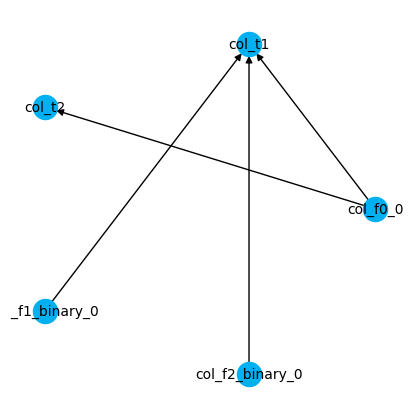

In [ ]:
# larger figure size
plt.figure(3,figsize=(4,4))
pos = nx.circular_layout(graph_nx_v1)
nx.draw(
    graph_nx_v1,
    pos,
    with_labels=True,
    node_size=300,
    font_size=10,
    font_color='black',
    node_color=COLORS[0]
)
plt.show()

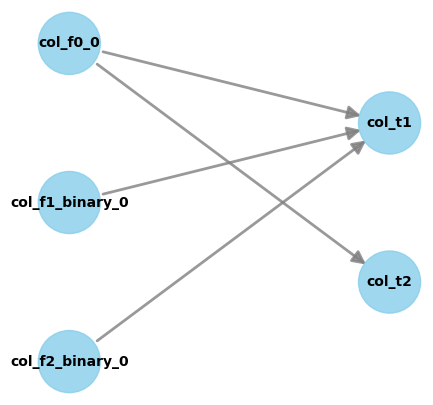

In [ ]:
plot(graph_nx_v1)

In [ ]:
# Define base graph
causal_model_v1 = gcm.InvertibleStructuralCausalModel(graph_nx_v1)

# Auto-assign causal mechanism (instead of manual)
gcm.auto.assign_causal_mechanisms(causal_model_v1, df_old)
gcm.fit(causal_model_v1, df_old)

Fitting causal mechanism of node col_f2_binary_0: 100%|██████████| 5/5 [00:00<00:00, 217.98it/s]


In [ ]:
attributions = gcm.distribution_change(
    causal_model_v1,
    df_old,
    df_new,
    "col_t1"
)
clear_output()
print(attributions)

{'col_f0_0': -0.003949166320789281, 'col_f1_binary_0': 0.00023521960873136225, 'col_f2_binary_0': 0.7231186045179516, 'col_t1': 0.014603105224925408}


We see that even if there's a misspecified node (col_f1_binary_0), the node identified as the main responsible is col_f2_binary_0, which is correct.

In [ ]:
# Original data
# Here, there's a new dataset w/o distributional change
SAMPLE_SIZE = 450 # New dataset doesn't need to have the same size as the previous one
ini_date = '2024-01-01'
col_date = pd.date_range(start=ini_date, periods=SAMPLE_SIZE)
col_f0_0 = np.random.random(SAMPLE_SIZE)
col_f1_binary_0 = np.random.randint(1, size=SAMPLE_SIZE) # binary column w/o influence on the target
col_f2_binary_0 = np.random.randint(1, size=SAMPLE_SIZE) # binary column w/ influence on the target
col_t1 = 5*col_f2_binary_0 + 0.3*col_f0_0 + np.random.random(SAMPLE_SIZE)
col_t2 = 5*col_f2_binary_0 + 0.2*col_f0_0 + np.random.random(SAMPLE_SIZE)

df_new_v1 = pd.DataFrame(
    {
        'col_date': col_date,
        'col_f0_0': col_f0_0,
        'col_f1_binary_0': col_f1_binary_0,
        'col_f2_binary_0': col_f2_binary_0,
        'col_t1': col_t1,
        'col_t2': col_t2,
    }
    )
df_new_v1.head(5)

,col_date,col_f0_0,col_f1_binary_0,col_f2_binary_0,col_t1,col_t2
0,2024-01-01,0.072503,0,0,0.494965,0.033385
1,2024-01-02,0.836689,0,0,0.495986,0.443009
2,2024-01-03,0.805421,0,0,0.978881,0.440540
3,2024-01-04,0.142059,0,0,0.132543,0.663547
4,2024-01-05,0.866016,0,0,0.310458,0.360890


In [ ]:
attributions = gcm.distribution_change(
    causal_model_v1,
    df_old,
    df_new_v1,
    "col_t1"
)
clear_output()
print(attributions) # Change is attributed mainly to col_feature4_lv1

{'col_f0_0': 0.01376560856756098, 'col_f1_binary_0': -0.003669778464059033, 'col_f2_binary_0': 0.02977608995767398, 'col_t1': 0.012396072799783234}


We see that when there's not distributional change, no node is identified as responsible.

In [ ]:
# Original data
# Here, there's a new dataset w/ distributional change, but through unmeasured variables (accounted in the noise)
SAMPLE_SIZE = 450 # New dataset doesn't need to have the same size as the previous one
ini_date = '2024-01-01'
col_date = pd.date_range(start=ini_date, periods=SAMPLE_SIZE)
col_f0_0 = np.random.random(SAMPLE_SIZE)
col_f1_binary_0 = np.random.randint(1, size=SAMPLE_SIZE) # binary column w/o influence on the target
col_f2_binary_0 = np.random.randint(1, size=SAMPLE_SIZE) # binary column w/ influence on the target
col_t1 = 5*col_f2_binary_0 + 0.3*col_f0_0 + 250*np.random.random(SAMPLE_SIZE)
col_t2 = 5*col_f2_binary_0 + 0.2*col_f0_0 + np.random.random(SAMPLE_SIZE)

df_new_v2 = pd.DataFrame(
    {
        'col_date': col_date,
        'col_f0_0': col_f0_0,
        'col_f1_binary_0': col_f1_binary_0,
        'col_f2_binary_0': col_f2_binary_0,
        'col_t1': col_t1,
        'col_t2': col_t2,
    }
    )
df_new_v2.head(5)

,col_date,col_f0_0,col_f1_binary_0,col_f2_binary_0,col_t1,col_t2
0,2024-01-01,0.232240,0,0,80.217103,0.552401
1,2024-01-02,0.656156,0,0,81.763921,0.792360
2,2024-01-03,0.839587,0,0,209.416433,0.678452
3,2024-01-04,0.487512,0,0,249.814714,0.403174
4,2024-01-05,0.716244,0,0,57.718339,0.324902


In [ ]:
attributions = gcm.distribution_change(
    causal_model_v1,
    df_old,
    df_new_v2,
    "col_t1"
)
clear_output()
print(attributions)

{'col_f0_0': -0.3314580112128807, 'col_f1_binary_0': -0.22922530455294482, 'col_f2_binary_0': -0.4293875835322404, 'col_t1': 6.619239517041911}


When the change is due to unmeasured variables, the distributional change is detected, but the "cause" given is the leaf node itself (col_t1 in this case)

#### Intrinsic causal influence

In [ ]:
contributions = gcm.intrinsic_causal_influence(
    causal_model,
    "col_target1"
)
clear_output()
print(contributions)

{'col_feature1_lv0': 0.005241715485530126, 'col_feature2_lv0': 0.0007695522524111014, 'col_feature3_lv0': 0.0006303122675468474, 'col_feature4_lv1': 0.0027246690149239335, 'col_target1': 0.0030672840694145422}


As we see, more variance is explained w/ col_feature1_lv0 than w/ col_feature4_lv1 even though the coefficient from col_feature4_lv1 is higher than that from col_feature1_lv0. The reason is that col_feature4_lv1 inherites part of it's values from col_feature1_lv0.

### 2.5. Tests

#### P-value
We can test which features are independent (or not) w.r.t. the target feature

In [ ]:
# Independence tests
p_value = gcm.independence_test(df['col_feature4_lv1'], df['col_target1'], conditioned_on=df['col_feature1_lv0'])
p_value

0.0

In [ ]:
# Independence tests
p_value = gcm.independence_test(df['col_feature6_lv1'], df['col_target1'], conditioned_on=df['col_feature2_lv0'])
p_value

0.5925804045457466

In [ ]:
df

,col_date,col_feature1_lv0,col_feature2_lv0,col_feature3_lv0,col_feature4_lv1,col_feature5_lv1,col_feature6_lv1,col_target1,col_target2,col_target3
0,2024-01-01,0.548814,0.592880,0.811518,0.387118,0.658956,0.260644,0.441297,0.403767,-0.179524
1,2024-01-02,0.715189,0.010064,0.476084,0.564882,0.510257,0.202379,0.446854,0.256862,-0.080143
2,2024-01-03,0.602763,0.475826,0.523156,0.642204,0.503731,0.067318,0.549723,0.310955,-0.022782
3,2024-01-04,0.544883,0.708770,0.250521,0.679520,0.394574,0.224043,0.528951,0.414025,-0.311891
4,2024-01-05,0.423655,0.043975,0.605043,0.631727,0.439337,0.169570,0.353248,0.163123,-0.147083
...,...,...,...,...,...,...,...,...,...,...
995,2026-09-22,0.097676,0.791282,0.941687,0.253794,0.601090,0.109624,0.364304,0.364301,-0.070094
996,2026-09-23,0.514922,0.721198,0.546133,0.394350,0.523208,0.111023,0.402484,0.386592,-0.387046
997,2026-09-24,0.938412,0.480108,0.323614,0.743784,0.511080,0.434094,0.655608,0.494791,-0.442088
998,2026-09-25,0.228647,0.643864,0.813545,0.670709,0.579622,0.330895,0.558506,0.395872,0.059317


#### Autoassignment summary

In [ ]:
causal_model = gcm.InvertibleStructuralCausalModel(graph_nx)
auto_assignment_summary = gcm.auto.assign_causal_mechanisms(causal_model, df)
print(auto_assignment_summary)

When using this auto assignment function, the given data is used to automatically assign a causal mechanism to each node. Note that causal mechanisms can also be customized and assigned manually.
The following types of causal mechanisms are considered for the automatic selection:

If root node:
An empirical distribution, i.e., the distribution is represented by randomly sampling from the provided data. This provides a flexible and non-parametric way to model the marginal distribution and is valid for all types of data modalities.

If non-root node and the data is continuous:
Additive Noise Models (ANM) of the form X_i = f(PA_i) + N_i, where PA_i are the parents of X_i and the unobserved noise N_i is assumed to be independent of PA_i.To select the best model for f, different regression models are evaluated and the model with the smallest mean squared error is selected.Note that minimizing the mean squared error here is equivalent to selecting the best choice of an ANM.

If non-root node

Test permutations of given graph: 100%|██████████| 50/50 [03:33<00:00,  4.28s/it]


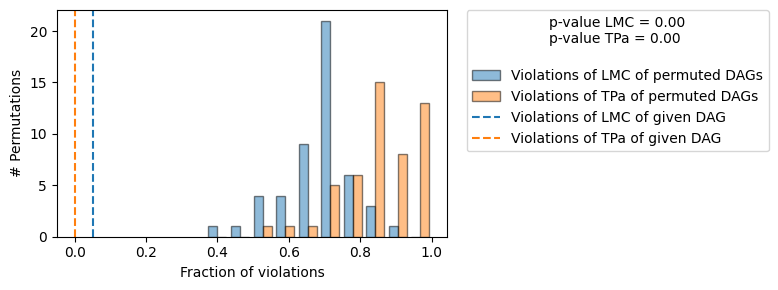

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [ ]:
print(gcm.evaluate_causal_model(causal_model, df))

# GCM w/ binary treatments

## 3.1. Syntethic data generation

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from dowhy import gcm

In [ ]:
# Note (1): lv0 features may affect both targets an other features of lv1
# Note (2): col_targets are leaf nodes that do not affect oneanother

SAMPLE_SIZE = 1000
col_date = pd.date_range(start='2024-01-01', periods=SAMPLE_SIZE)
col_feature1_lv0 = np.random.random(SAMPLE_SIZE)
col_feature2_lv0 = np.random.random(SAMPLE_SIZE)
col_feature3_lv0 = np.random.random(SAMPLE_SIZE)
col_feature7_lv0 = np.random.randint(2, size=SAMPLE_SIZE)
col_feature4_lv1 = 0.2*col_feature1_lv0 + 0.67*np.random.random(SAMPLE_SIZE)
col_feature5_lv1 = 0.3*col_feature1_lv0 + 0.1*col_feature2_lv0 + 0.5*col_feature3_lv0 + 0.1*np.random.random(SAMPLE_SIZE)
col_feature6_lv1 = 0.05*col_feature3_lv0 + 0.6*np.random.random(SAMPLE_SIZE)
col_target1 = 0.2*col_feature1_lv0 + 0.1*col_feature2_lv0 + 0.1*col_feature3_lv0 + 0.3*col_feature4_lv1 + 0.2*np.random.random(SAMPLE_SIZE)
col_target2 = 0.1*col_feature1_lv0 + 0.2*col_feature2_lv0 + 0.1*col_feature5_lv1 + 0.4*col_feature6_lv1 + 0.1*np.random.random(SAMPLE_SIZE)
col_target3 = -0.3*col_feature1_lv0 + -0.3*col_feature2_lv0 + -0.1*col_feature5_lv1 + 0.5*np.random.random(SAMPLE_SIZE)
col_target4 = 5*col_feature7_lv0 + np.random.random(SAMPLE_SIZE)

df = pd.DataFrame(
    {
        'col_date': col_date,
        'col_feature1_lv0': col_feature1_lv0,
        'col_feature2_lv0': col_feature2_lv0,
        'col_feature3_lv0': col_feature3_lv0,
        'col_feature7_lv0': col_feature7_lv0,
        'col_feature4_lv1': col_feature4_lv1,
        'col_feature5_lv1': col_feature5_lv1,
        'col_feature6_lv1': col_feature6_lv1,
        'col_target1': col_target1,
        'col_target2': col_target2,
        'col_target3': col_target3,
        'col_target4': col_target4
    }
    )
df.head(5)

,col_date,col_feature1_lv0,col_feature2_lv0,col_feature3_lv0,col_feature7_lv0,col_feature4_lv1,col_feature5_lv1,col_feature6_lv1,col_target1,col_target2,col_target3,col_target4
0,2024-01-01,0.403823,0.953930,0.012592,0,0.663924,0.253090,0.242858,0.527834,0.398332,-0.062171,0.939862
1,2024-01-02,0.427280,0.500698,0.085764,1,0.726345,0.233459,0.327478,0.556851,0.379700,-0.163885,5.325023
2,2024-01-03,0.700312,0.949408,0.916884,1,0.760582,0.774437,0.143296,0.566860,0.448043,-0.483539,5.559843
3,2024-01-04,0.460273,0.966551,0.189259,1,0.645537,0.350631,0.106063,0.526670,0.336427,-0.091814,5.213337
4,2024-01-05,0.247367,0.282675,0.645792,0,0.497897,0.459954,0.344505,0.394777,0.351003,-0.101925,0.029352


In [ ]:
# Target columns
list_cols_lv0    = ['col_feature1_lv0', 'col_feature2_lv0', 'col_feature3_lv0', 'col_feature7_lv0']
list_cols_target = ['col_target1', 'col_target2', 'col_target3', 'col_target4']
list_cols_middle = [x for x in list(df.columns) if x not in list_cols_lv0 + list_cols_target and x != 'col_date']

## 3.2. Causal graph

In [ ]:
COLORS = [
    '#00B0F0',
    '#FF0000'
]

In [ ]:
# Define graph dependencies
edges = [
    ('col_feature1_lv0', 'col_feature4_lv1'),
    ('col_feature1_lv0', 'col_feature5_lv1'),
    ('col_feature1_lv0', 'col_target1'),
    ('col_feature1_lv0', 'col_target2'),
    ('col_feature1_lv0', 'col_target3'),

    ('col_feature2_lv0', 'col_feature5_lv1'),
    ('col_feature2_lv0', 'col_target1'),
    ('col_feature2_lv0', 'col_target2'),
    ('col_feature2_lv0', 'col_target3'),

    ('col_feature3_lv0', 'col_feature5_lv1'),
    ('col_feature3_lv0', 'col_feature6_lv1'),
    ('col_feature3_lv0', 'col_target1'),

    ('col_feature4_lv1', 'col_target1'),

    ('col_feature5_lv1', 'col_target2'),
    ('col_feature5_lv1', 'col_target3'),

    ('col_feature6_lv1', 'col_target2'),

    ('col_feature7_lv0', 'col_target4'),
    ]
graph_nx = nx.DiGraph([(edge[0], edge[1]) for edge in edges])

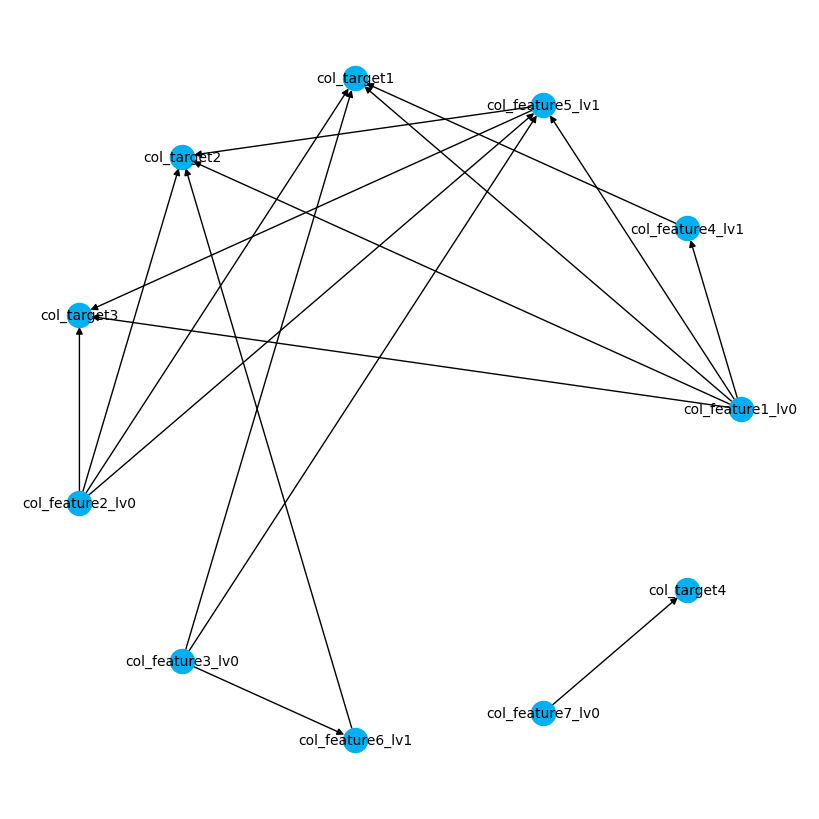

In [ ]:
# larger figure size
plt.figure(3,figsize=(8,8))
pos = nx.circular_layout(graph_nx)
nx.draw(
    graph_nx,
    pos,
    with_labels=True,
    node_size=300,
    font_size=10,
    font_color='black',
    node_color=COLORS[0]
)
plt.show()

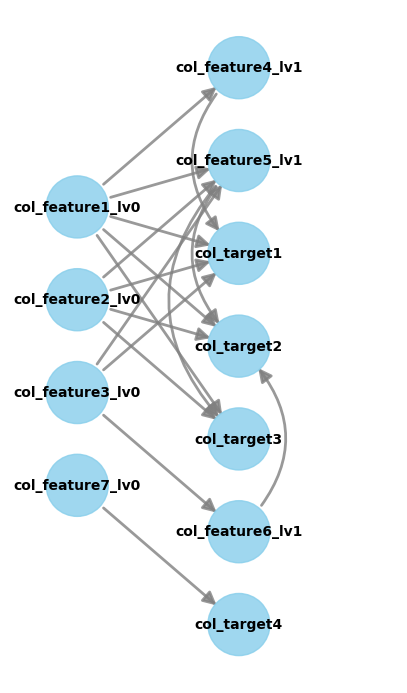

In [ ]:
plot(graph_nx)

## 3.3. Causal modeling

In [ ]:
# Define base graph
causal_model = gcm.InvertibleStructuralCausalModel(graph_nx)

# Auto-assign causal mechanism (instead of manual)
gcm.auto.assign_causal_mechanisms(causal_model, df)
gcm.fit(causal_model, df)

Fitting causal mechanism of node col_target4: 100%|██████████| 11/11 [00:00<00:00, 84.98it/s]


In [ ]:
# Get arrow strength
# By default, arrow_strength employs KL divergence for measuring the arrow strength for categorical target
# Results in terms of the ouctome variable variance change given we remove the edge from the source variable
gcm.arrow_strength(causal_model, 'col_target4')

{('col_feature7_lv0', 'col_target4'): 6.203518075235843}

## 3.4. Estimate treatment effect

In [ ]:
# Reference datapoints
X_test = df[4:5].copy().drop(columns=['col_date'])
display(X_test)
y_test = X_test[list_cols_target].copy()
X_test = X_test.drop(columns=list_cols_target)[list_cols_lv0]
#dct_input = {col_input: lambda x: X_test[col_input].values[0] for col_input in list(X_test.columns)}
#dct_input_base = {col_input: lambda x: 0 for col_input in list(X_test.columns)}
dct_input = {'col_feature7_lv0': lambda x: 1}
dct_input_base = {'col_feature7_lv0': lambda x: 0}

# Average causal effect
idx_check = 3
estim_effect = gcm.average_causal_effect(
    causal_model,
    'col_target4',
    interventions_alternative=dct_input,
    interventions_reference=dct_input_base,
    observed_data=df # Using the original data
)
print(list_cols_target[idx_check])
print(y_test['col_target4'].values[0], estim_effect)

,col_feature1_lv0,col_feature2_lv0,col_feature3_lv0,col_feature7_lv0,col_feature4_lv1,col_feature5_lv1,col_feature6_lv1,col_target1,col_target2,col_target3,col_target4
4,0.247367,0.282675,0.645792,0,0.497897,0.459954,0.344505,0.394777,0.351003,-0.101925,0.029352


col_target4
0.029351820007960994 5.000952037367987


## 3.5. Feature importance & predictions

In [ ]:
# Estimate causal effects
for col_target_iter in list_cols_middle + list_cols_target:
  print("*"*50)
  print(col_target_iter)
  list_col_nodes_iter = list(set([edge[0] for edge in edges if edge[1]==col_target_iter]))
  for col_node in list_col_nodes_iter:
    result = gcm.average_causal_effect(
        causal_model,
        col_target_iter,
        interventions_alternative={col_node: lambda x: 1},
        interventions_reference={col_node: lambda x: 0},
        num_samples_to_draw=2000
    )
    print(col_node, ":", np.round(result, 3))
  print("*"*50)
  print()

**************************************************
col_feature4_lv1
col_feature1_lv0 : 0.219
**************************************************

**************************************************
col_feature5_lv1
col_feature2_lv0 : 0.094
col_feature3_lv0 : 0.503
col_feature1_lv0 : 0.305
**************************************************

**************************************************
col_feature6_lv1
col_feature3_lv0 : 0.04
**************************************************

**************************************************
col_target1
col_feature4_lv1 : 0.295
col_feature2_lv0 : 0.103
col_feature3_lv0 : 0.1
col_feature1_lv0 : 0.273
**************************************************

**************************************************
col_target2
col_feature2_lv0 : 0.204
col_feature6_lv1 : 0.399
col_feature1_lv0 : 0.132
col_feature5_lv1 : 0.104
**************************************************

**************************************************
col_target3
col_feature2_lv0 : -0.32


In [ ]:
# Predictions based on constant causal effects coefficients
df_coeff = pd.DataFrame()
for col_target_iter in list_cols_target: # Keep only final nodes
  print("*"*50)
  print(col_target_iter)
  list_col_nodes_iter = list(set([edge[0] for edge in edges if edge[1]==col_target_iter]))
  for col_node in list_col_nodes_iter:
    result = gcm.average_causal_effect(
        causal_model,
        col_target_iter,
        interventions_alternative={col_node: lambda x: 1},
        interventions_reference={col_node: lambda x: 0},
        num_samples_to_draw=2000
    )
    print(col_node, ":", np.round(result, 3))
    df_coeff_iter = pd.DataFrame(
        {
            'col_root':   [col_node],
            'col_target': [col_target_iter],
            'feature_importance': [result]
        }
        )
    df_coeff = pd.concat([df_coeff, df_coeff_iter])
  print("*"*50)
  print()
df_coeff.head()

**************************************************
col_target1
col_feature4_lv1 : 0.297
col_feature2_lv0 : 0.104
col_feature3_lv0 : 0.1
col_feature1_lv0 : 0.272
**************************************************

**************************************************
col_target2
col_feature2_lv0 : 0.204
col_feature6_lv1 : 0.398
col_feature1_lv0 : 0.134
col_feature5_lv1 : 0.106
**************************************************

**************************************************
col_target3
col_feature2_lv0 : -0.324
col_feature1_lv0 : -0.345
col_feature5_lv1 : -0.122
**************************************************

**************************************************
col_target4
col_feature7_lv0 : 4.986
**************************************************



,col_root,col_target,feature_importance
0,col_feature4_lv1,col_target1,0.296529
0,col_feature2_lv0,col_target1,0.104362
0,col_feature3_lv0,col_target1,0.100173
0,col_feature1_lv0,col_target1,0.271690
0,col_feature2_lv0,col_target2,0.203948


In [ ]:
# Check for one datapoint
X_test = df[4:5].copy().drop(columns=['col_date'])
y_test = X_test[list_cols_target].copy()
#X_test = X_test.drop(columns=list_cols_target)[list_cols_lv0]
X_test = X_test.drop(columns=list_cols_target)

df_coeff['y_pred_aux'] = df_coeff.apply(
    lambda x: x['feature_importance']*X_test[x['col_root']], axis=1
)
display(df_coeff[['col_target', 'y_pred_aux']].groupby(by=['col_target']).sum().reset_index().T)
display(y_test)

,0,1,2,3
col_target,col_target1,col_target2,col_target3,col_target4
y_pred_aux,0.309039,0.276853,-0.233087,0.0


,col_target1,col_target2,col_target3,col_target4
4,0.394777,0.351003,-0.101925,0.029352


In [ ]:
# Reference input nodes
X_test = df[4:5].copy().drop(columns=['col_date'])
y_test = X_test[list_cols_target].copy()
#X_test = X_test.drop(columns=list_cols_target)[list_cols_lv0]
X_test = X_test.drop(columns=list_cols_target)

#dct_input = {col_input: lambda x: X_test[col_input].values[0] for col_input in list(X_test.columns)}
dct_input = OrderedDict()
for col_input in list(X_test.columns):
  value_iter = X_test[col_input].values[0]
  constant_lambda = lambda x, value=value_iter: value
  dct_input[col_input] = constant_lambda

X_pred = gcm.interventional_samples(
    causal_model,
    dct_input,
    num_samples_to_draw=1000
)
y_pred = pd.DataFrame(X_pred[list_cols_target].mean()).T
display(X_pred.head(2))
display(y_pred)
display(y_test)

,col_feature1_lv0,col_feature2_lv0,col_feature3_lv0,col_feature7_lv0,col_feature4_lv1,col_feature5_lv1,col_feature6_lv1,col_target4,col_target1,col_target3,col_target2
0,0.247367,0.282675,0.645792,0,0.497897,0.459954,0.344505,0.522102,0.378135,-0.190106,0.267777
1,0.247367,0.282675,0.645792,0,0.497897,0.459954,0.344505,0.308986,0.437749,-0.064101,0.361354


,col_target1,col_target2,col_target3,col_target4
0,0.395131,0.318526,0.045412,0.511015


,col_target1,col_target2,col_target3,col_target4
4,0.394777,0.351003,-0.101925,0.029352


In [ ]:
# Prediction alternative

# Reference input nodes
X_test = df[4:5].copy().drop(columns=['col_date'])
y_test = X_test[list_cols_target].copy()
#X_test = X_test.drop(columns=list_cols_target)[list_cols_lv0]
X_test = X_test.drop(columns=list_cols_target)

df_pred = pd.DataFrame()
for col_target_iter in list_cols_target: # Keep only final nodes
  print("*"*50)
  print(col_target_iter)
  list_col_nodes_iter = list(set([edge[0] for edge in edges if edge[1]==col_target_iter]))
  for col_node in list_col_nodes_iter:
    result = gcm.average_causal_effect(
        causal_model,
        col_target_iter,
        interventions_alternative = {col_node: lambda x: X_test[col_node].values[0]},
        interventions_reference   = {col_node: lambda x: 0},
        num_samples_to_draw=2000
    )
    print(col_node, ":", np.round(result, 3))
    df_pred_iter = pd.DataFrame(
        {
            'col_root':   [col_node],
            'col_target': [col_target_iter],
            'y_pred_aux': [result]
        }
        )
    df_pred = pd.concat([df_pred, df_pred_iter])
  print("*"*50)
  print()
display(df_pred.head())
display(df_pred[['col_target', 'y_pred_aux']].groupby(by=['col_target']).sum().reset_index().T)
display(y_test)

**************************************************
col_target1
col_feature4_lv1 : 0.148
col_feature2_lv0 : 0.032
col_feature3_lv0 : 0.065
col_feature1_lv0 : 0.068
**************************************************

**************************************************
col_target2
col_feature2_lv0 : 0.057
col_feature6_lv1 : 0.138
col_feature1_lv0 : 0.035
col_feature5_lv1 : 0.049
**************************************************

**************************************************
col_target3
col_feature2_lv0 : -0.087
col_feature1_lv0 : -0.087
col_feature5_lv1 : -0.055
**************************************************

**************************************************
col_target4
col_feature7_lv0 : -0.009
**************************************************



,col_root,col_target,y_pred_aux
0,col_feature4_lv1,col_target1,0.148467
0,col_feature2_lv0,col_target1,0.031637
0,col_feature3_lv0,col_target1,0.065122
0,col_feature1_lv0,col_target1,0.067735
0,col_feature2_lv0,col_target2,0.056876


,0,1,2,3
col_target,col_target1,col_target2,col_target3,col_target4
y_pred_aux,0.312961,0.278172,-0.22791,-0.009411


,col_target1,col_target2,col_target3,col_target4
4,0.394777,0.351003,-0.101925,0.029352


In [ ]:
# Predictions based on constant causal effects coefficients
df_coeff = pd.DataFrame()
for col_target_iter in list_cols_target: # Keep only final nodes
  print("*"*50)
  print(col_target_iter)
  list_col_nodes_iter = list(set([edge[0] for edge in edges if edge[1]==col_target_iter]))
  for col_node in list_col_nodes_iter:
    result = gcm.average_causal_effect(
        causal_model,
        col_target_iter,
        interventions_alternative = {col_node: lambda x: 1},
        interventions_reference   = {col_node: lambda x: 0},
        num_samples_to_draw=2000
    )
    print(col_node, ":", np.round(result, 3))
    df_coeff_iter = pd.DataFrame(
        {
            'col_root':   [col_node],
            'col_target': [col_target_iter],
            'feature_importance': [result]
        }
        )
    df_coeff = pd.concat([df_coeff, df_coeff_iter])
  print("*"*50)
  print()
df_coeff.head()

**************************************************
col_target1
col_feature4_lv1 : 0.296
col_feature2_lv0 : 0.101
col_feature3_lv0 : 0.103
col_feature1_lv0 : 0.275
**************************************************

**************************************************
col_target2
col_feature2_lv0 : 0.204
col_feature6_lv1 : 0.398
col_feature1_lv0 : 0.131
col_feature5_lv1 : 0.104
**************************************************

**************************************************
col_target3
col_feature2_lv0 : -0.318
col_feature1_lv0 : -0.331
col_feature5_lv1 : -0.127
**************************************************

**************************************************
col_target4
col_feature7_lv0 : 5.001
**************************************************



,col_root,col_target,feature_importance
0,col_feature4_lv1,col_target1,0.295906
0,col_feature2_lv0,col_target1,0.101101
0,col_feature3_lv0,col_target1,0.102972
0,col_feature1_lv0,col_target1,0.275098
0,col_feature2_lv0,col_target2,0.204249


In [ ]:
# Check for one datapoint
X_test = df[4:5].copy().drop(columns=['col_date'])
y_test = X_test[list_cols_target].copy()
#X_test = X_test.drop(columns=list_cols_target)[list_cols_lv0]
X_test = X_test.drop(columns=list_cols_target)

df_coeff['y_pred_aux'] = df_coeff.apply(
    lambda x: x['feature_importance']*X_test[x['col_root']], axis=1
)
display(df_coeff[['col_target', 'y_pred_aux']].groupby(by=['col_target']).sum().reset_index())
display(y_test)

,col_target,y_pred_aux
0,col_target1,0.310458
1,col_target2,0.275224
2,col_target3,-0.230282
3,col_target4,0.000000


,col_target1,col_target2,col_target3,col_target4
4,0.394777,0.351003,-0.101925,0.029352


# Causal Discovery

Using CausalLearn

### 0. Synthetic data generation

In [ ]:
# Note (1): lv0 features may affect both targets an other features of lv1
# Note (2): col_targets are leaf nodes that do not affect oneanother

SAMPLE_SIZE = 1000
col_date = pd.date_range(start='2024-01-01', periods=SAMPLE_SIZE)
col_feature1_lv0 = np.random.random(SAMPLE_SIZE)
col_feature2_lv0 = np.random.random(SAMPLE_SIZE)
col_feature3_lv0 = np.random.random(SAMPLE_SIZE)
col_feature4_lv1 = 0.2*col_feature1_lv0 + 0.67*np.random.random(SAMPLE_SIZE)
col_feature5_lv1 = 0.3*col_feature1_lv0 + 0.1*col_feature2_lv0 + 0.5*col_feature3_lv0 + 0.1*np.random.random(SAMPLE_SIZE)
col_feature6_lv1 = 0.05*col_feature3_lv0 + 0.6*np.random.random(SAMPLE_SIZE)
col_target1 = 0.2*col_feature1_lv0 + 0.1*col_feature2_lv0 + 0.1*col_feature3_lv0 + 0.3*col_feature4_lv1 + 0.2*np.random.random(SAMPLE_SIZE)
col_target2 = 0.1*col_feature1_lv0 + 0.2*col_feature2_lv0 + 0.1*col_feature5_lv1 + 0.4*col_feature6_lv1 + 0.1*np.random.random(SAMPLE_SIZE)
col_target3 = -0.3*col_feature1_lv0 + -0.3*col_feature2_lv0 + -0.1*col_feature5_lv1 + 0.5*np.random.random(SAMPLE_SIZE)

df = pd.DataFrame(
    {
        'col_date': col_date,
        'col_feature1_lv0': col_feature1_lv0,
        'col_feature2_lv0': col_feature2_lv0,
        'col_feature3_lv0': col_feature3_lv0,
        'col_feature4_lv1': col_feature4_lv1,
        'col_feature5_lv1': col_feature5_lv1,
        'col_feature6_lv1': col_feature6_lv1,
        'col_target1': col_target1,
        'col_target2': col_target2,
        'col_target3': col_target3
    }
    )
df.head(5)

,col_date,col_feature1_lv0,col_feature2_lv0,col_feature3_lv0,col_feature4_lv1,col_feature5_lv1,col_feature6_lv1,col_target1,col_target2,col_target3
0,2024-01-01,0.548814,0.592880,0.811518,0.387118,0.658956,0.260644,0.441297,0.403767,-0.179524
1,2024-01-02,0.715189,0.010064,0.476084,0.564882,0.510257,0.202379,0.446854,0.256862,-0.080143
2,2024-01-03,0.602763,0.475826,0.523156,0.642204,0.503731,0.067318,0.549723,0.310955,-0.022782
3,2024-01-04,0.544883,0.708770,0.250521,0.679520,0.394574,0.224043,0.528951,0.414025,-0.311891
4,2024-01-05,0.423655,0.043975,0.605043,0.631727,0.439337,0.169570,0.353248,0.163123,-0.147083


In [ ]:
# Target columns
list_cols_lv0    = ['col_feature1_lv0', 'col_feature2_lv0', 'col_feature3_lv0']
list_cols_target = ['col_target1', 'col_target2', 'col_target3']
list_cols_middle = [x for x in list(df.columns) if x not in list_cols_lv0 + list_cols_target and x != 'col_date']

### 1. PC algorithm

In [ ]:
from causallearn.search.ConstraintBased.PC import pc
cg = pc(df.drop(columns=['col_date']).to_numpy())

  0%|          | 0/9 [00:00<?, ?it/s]

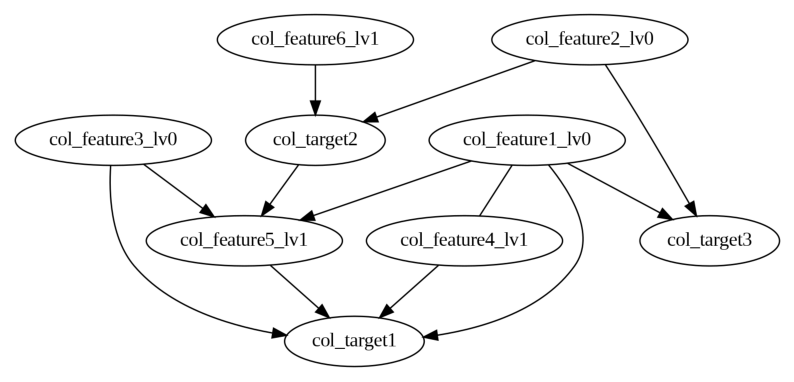

In [ ]:
# Visualization using pydot
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io
plt.figure(figsize=(10,10))
labels = list(df.drop(columns=['col_date']).columns)
pyd = GraphUtils.to_pydot(cg.G, labels=labels)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

### 2. GES algorithm

In [ ]:
from causallearn.search.ScoreBased.GES import ges
Record = ges(df.drop(columns=['col_date']).to_numpy())

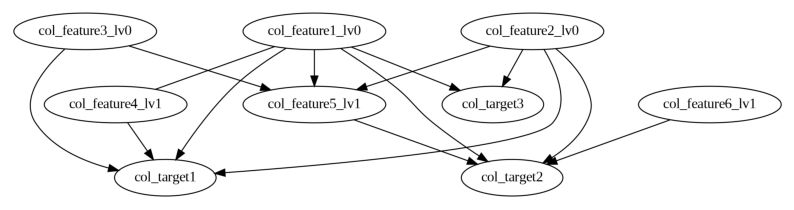

In [ ]:
# Visualization using pydot
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io
plt.figure(figsize=(10,10))
pyd = GraphUtils.to_pydot(Record['G'], labels=labels)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

### 3. LiNGAM

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


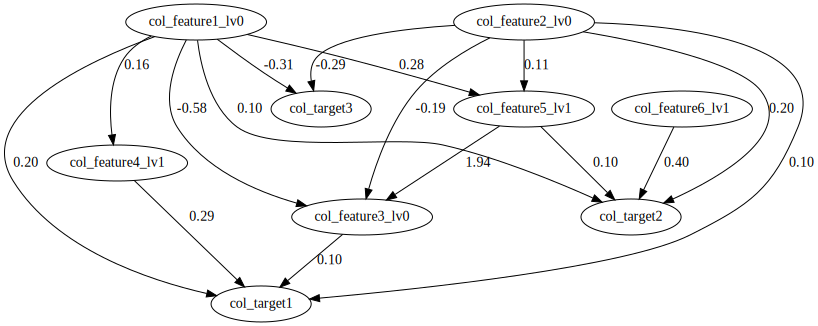

In [ ]:
from causallearn.search.FCMBased import lingam
model = lingam.ICALiNGAM()
model.fit(df.drop(columns=['col_date']).to_numpy())

from causallearn.search.FCMBased.lingam.utils import make_dot
make_dot(model.adjacency_matrix_, labels=labels)

### 4. Falsify graph

In [ ]:
# Define graph dependencies
edges = [
    ('col_feature1_lv0', 'col_feature4_lv1'),
    ('col_feature1_lv0', 'col_feature5_lv1'),
    ('col_feature1_lv0', 'col_target1'),
    ('col_feature1_lv0', 'col_target2'),
    ('col_feature1_lv0', 'col_target3'),

    ('col_feature2_lv0', 'col_feature5_lv1'),
    ('col_feature2_lv0', 'col_target1'),
    ('col_feature2_lv0', 'col_target2'),
    ('col_feature2_lv0', 'col_target3'),

    ('col_feature3_lv0', 'col_feature5_lv1'),
    ('col_feature3_lv0', 'col_feature6_lv1'),
    ('col_feature3_lv0', 'col_target1'),

    ('col_feature4_lv1', 'col_target1'),

    ('col_feature5_lv1', 'col_target2'),
    ('col_feature5_lv1', 'col_target3'),

    ('col_feature6_lv1', 'col_target2')
    ]
graph_nx = nx.DiGraph([(edge[0], edge[1]) for edge in edges])

Test permutations of given graph: 100%|██████████| 20/20 [11:19<00:00, 33.97s/it]


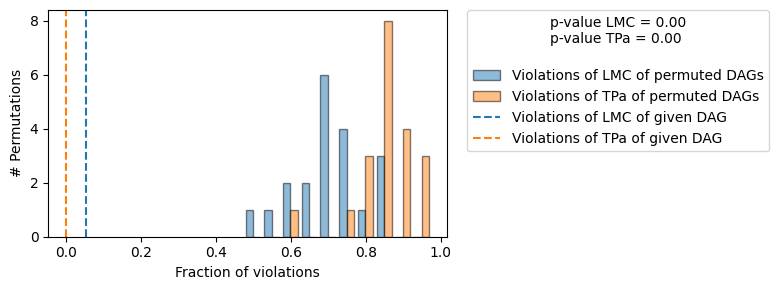

+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is informative because 0 / 20 of the permutations lie in the Markov                     |
| equivalence class of the given DAG (p-value: 0.00).                                                   |
| The given DAG violates 2/38 LMCs and is better than 100.0% of the permuted DAGs (p-value: 0.00).      |
| Based on the provided significance level (0.05) and because the DAG is informative,                   |
| we do not reject the DAG.                                                                             |
+-------------------------------------------------------------------------------------------------------+


In [ ]:
# Note: This cell takes a while to execute
from dowhy.gcm.falsify import FalsifyConst, falsify_graph, plot_local_insights, run_validations, apply_suggestions
result = falsify_graph(graph_nx, df.drop(columns=['col_date']), plot_histogram=True)
# Summarize the result
print(result)

In [ ]:
# Plot suggestions
#plot_local_insights(graph_nx, cg, method=FalsifyConst.VALIDATE_CM)

In [ ]:
# TODO: Enforce constraints

### Prior knowledge

Using DirectLiNGAM

* Reference: https://causal-learn.readthedocs.io/en/latest/search_methods_index/Causal%20discovery%20methods%20based%20on%20constrained%20functional%20causal%20models/lingam.html

* 0: does not have a directed path to
* 1: has a directed path to
* -1: No prior knowledge is available to know if either of the two cases above (0 or 1) is true.

In [ ]:
#base_vector = [0 for x in len(df.drop(columns=['col_date']).columns)]
list_cols = list(df.drop(columns=['col_date']).columns)
prior_knowledge = []
for col_iter in list_cols:
  # Root nodes (first layer) do not have relationships between them
  if col_iter in list_cols_lv0:
    x_iter = [0 if x in list_cols_lv0 else -1 for x in list_cols]
  # Target nodes do not have descendants
  elif col_iter in list_cols_target:
    #x_iter = [0 if x else -1 for x in list_cols_target]
    x_iter = [0 for x in list_cols]
  # No self-relationships & first layer nodes cannot be descendants
  else:
    x_iter = [0 if x==col_iter or x in list_cols_lv0 else -1 for x in list_cols]

  prior_knowledge.append(x_iter)
prior_knowledge = np.array(prior_knowledge).transpose()
print(prior_knowledge)

[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [-1 -1 -1  0 -1 -1  0  0  0]
 [-1 -1 -1 -1  0 -1  0  0  0]
 [-1 -1 -1 -1 -1  0  0  0  0]
 [-1 -1 -1 -1 -1 -1  0  0  0]
 [-1 -1 -1 -1 -1 -1  0  0  0]
 [-1 -1 -1 -1 -1 -1  0  0  0]]


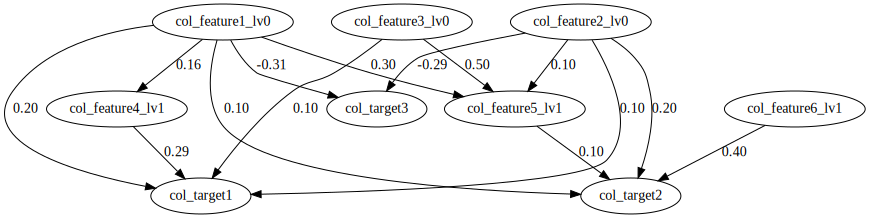

In [ ]:
from causallearn.search.FCMBased import lingam
model = lingam.DirectLiNGAM(prior_knowledge=prior_knowledge)
model.fit(df.drop(columns=['col_date']).to_numpy())

from causallearn.search.FCMBased.lingam.utils import make_dot
make_dot(model.adjacency_matrix_, labels=labels)

In [ ]:
'''
# Target columns
list_cols_lv0    = ['col_feature1_lv0', 'col_feature2_lv0', 'col_feature3_lv0']
list_cols_target = ['col_target1', 'col_target2', 'col_target3']
list_cols_middle = [x for x in list(df.columns) if x not in list_cols_lv0 + list_cols_target and x != 'col_date']
'''

In [ ]:
model.adjacency_matrix_

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.15699564,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.29984503,  0.09833417,  0.4962604 ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.20121015,  0.09956089,  0.09513113,  0.28686717,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.099118  ,  0.20192249,  0.        ,  0.        ,  0

In [ ]:
df_coeffs = pd.DataFrame(model.adjacency_matrix_).T
df_coeffs.columns = labels
df_coeffs.index = labels
display(df_coeffs)

,col_feature1_lv0,col_feature2_lv0,col_feature3_lv0,col_feature4_lv1,col_feature5_lv1,col_feature6_lv1,col_target1,col_target2,col_target3
col_feature1_lv0,0.0,0.0,0.0,0.176946,0.299831,0.0,0.201210,0.099118,-0.311359
col_feature2_lv0,0.0,0.0,0.0,0.000000,0.098295,0.0,0.099561,0.201922,-0.288989
col_feature3_lv0,0.0,0.0,0.0,0.000000,0.496252,0.0,0.095131,0.000000,0.000000
col_feature4_lv1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.286867,0.000000,0.000000
col_feature5_lv1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.101743,0.000000
col_feature6_lv1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.397855,0.000000
col_target1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
col_target2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
col_target3,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


In [ ]:
# Example prediction -> TODO
df_target_coeff = df_coeffs[~df_coeffs.index.isin(list_cols_target)].drop(columns=list_cols_lv0)#[list_cols_target]
#df_target_coeff = df_coeffs[list_cols_target]
X_test = df.tail(1).drop(columns=['col_date']).copy()
y_test = X_test[list_cols_target].copy()
X_test = X_test.drop(columns=list_cols_target)
display(y_test)
display(X_test)
display(df_target_coeff)

dct_features = {}
# Predictions for middle columns
for col_middle in list_cols_middle:
  break

,col_target1,col_target2,col_target3
999,0.46808,0.417019,0.042541


,col_feature1_lv0,col_feature2_lv0,col_feature3_lv0,col_feature4_lv1,col_feature5_lv1,col_feature6_lv1
999,0.677141,0.501773,0.6974,0.342015,0.697879,0.2386


,col_feature4_lv1,col_feature5_lv1,col_feature6_lv1,col_target1,col_target2,col_target3
col_feature1_lv0,0.176946,0.299831,0.0,0.201210,0.099118,-0.311359
col_feature2_lv0,0.000000,0.098295,0.0,0.099561,0.201922,-0.288989
col_feature3_lv0,0.000000,0.496252,0.0,0.095131,0.000000,0.000000
col_feature4_lv1,0.000000,0.000000,0.0,0.286867,0.000000,0.000000
col_feature5_lv1,0.000000,0.000000,0.0,0.000000,0.101743,0.000000
col_feature6_lv1,0.000000,0.000000,0.0,0.000000,0.397855,0.000000


In [ ]:
-0.31*0.677141 - 0.288989*0.501773

-0.354920587497

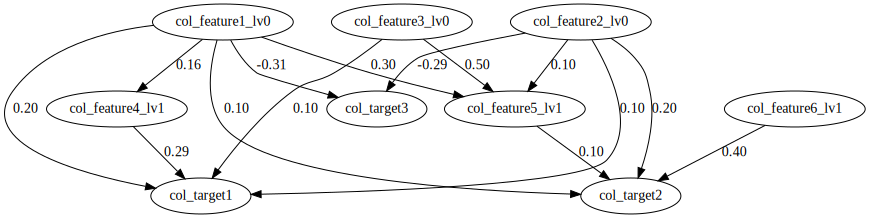

In [ ]:
# Alternatives with other params (I)
from causallearn.search.FCMBased import lingam
model = lingam.DirectLiNGAM(prior_knowledge=prior_knowledge, apply_prior_knowledge_softly=True)
model.fit(df.drop(columns=['col_date']).to_numpy())

from causallearn.search.FCMBased.lingam.utils import make_dot
make_dot(model.adjacency_matrix_, labels=labels)

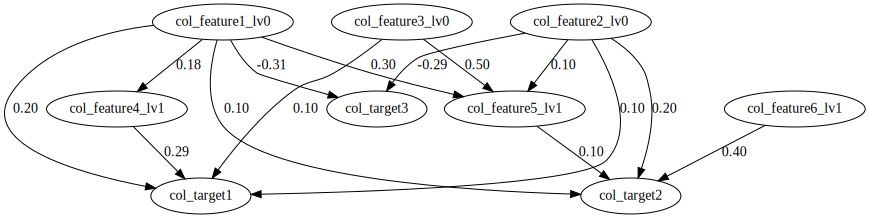

In [ ]:
# Alternatives with other params (II)
# This cell takes a while to execute
from causallearn.search.FCMBased import lingam
model = lingam.DirectLiNGAM(prior_knowledge=prior_knowledge, measure='kernel')
model.fit(df.drop(columns=['col_date']).to_numpy())

from causallearn.search.FCMBased.lingam.utils import make_dot
make_dot(model.adjacency_matrix_, labels=labels)